# Gaussian Processes and Various Covariance Kernel Methods

In this worksheet, we will introduce and work with *Gaussian Processes* (GP) and covariance kernels in Python. A good starting point is the GP Regression [documentation](https://scikit-learn.org/1.5/modules/gaussian_process.html#gaussian-process-regression-gpr) and [examples](https://scikit-learn.org/1.5/auto_examples/gaussian_process/index.html) in `sklearn`.


## 1. GP Simulation ( various kernels; gp.sample_y)

### 1.1. ConstantKernel & RBF
Consider the GP with 
$$ y(x) \sim \mathcal{GP}\left( \; \mu(x)=0 ,\;  K(x, x') = C \times \exp\left\{ -  \frac{  \|x-x'\|_2^2 }{2\ell^2} \right\} \; \right)$$
The following code generates 10 sample paths from this GP, for hyperparameters $C=1, \ell =1$.  

1**2 * RBF(length_scale=1)


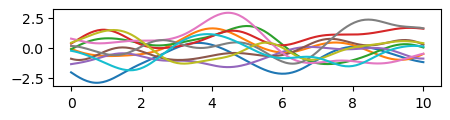

In [1]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C; import matplotlib.pyplot as plt

x = np.linspace(0, 10, 200).reshape(-1, 1) # expressed as 2D array

kernel = C(constant_value = 1.0) * RBF(length_scale = 1.0) # define kernel 
print(kernel) # verify kernel

gp = GaussianProcessRegressor( kernel ) # define GP
y_smpl = gp.sample_y( x, n_samples = 10 ) # draw samples
plt.figure(figsize=(5, 1)); plt.plot( x, y_smpl);

### 1.2. Dot-product kernel
Modify this code to draw samples from a GP with a [dot-product kernel](https://scikit-learn.org/1.5/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html#). Note that this is equivalent to Bayesian SLR, so your paths should be straight lines

DotProduct kernel:$$K(x,x')=\sigma_0^2+x\cdot x'$$
Why sample path are straight lines?
$$\begin{bmatrix}y(1)-y(0)\\ \frac{y(x)-y(0)}{x}\end{bmatrix}\sim N_2(0,\begin{bmatrix}1&1\\1&1\end{bmatrix})$$
$$Corr(y(1)-y(0),\frac{y(x)-y(0)}{x})=1\Rightarrow y(1)-y(0)=a\frac{y(x)-y(0)}{x}$$
$$ Var(y(1)-y(0))=Var(\frac{y(x)-y(0)}{x})\Rightarrow a=1$$ so$$y(1)-y(0)=\frac{y(x)-y(0)}{x}$$i.e., they have the same slope

DotProduct(sigma_0=1)


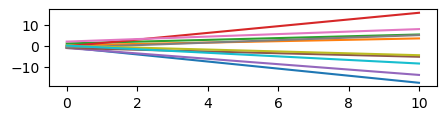

In [2]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor; import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import DotProduct
x = np.linspace(0, 10, 200).reshape(-1, 1) # expressed as 2D array

kernel = DotProduct(sigma_0 = 1, sigma_0_bounds = "fixed") 

print(kernel) # verify kernel
gp = GaussianProcessRegressor( kernel )
y_smpl = gp.sample_y( x, n_samples = 10, random_state=0 ) # setting RNG seed w/ random_state
plt.figure(figsize=(5, 1));plt.plot( x, y_smpl);

In class, we saw that you can combine kernels by adding or multiplying them. Using the `DotProduct` kernel and mathematical operators (`+/*/**`) in Python, specify the following kernel and sample 10 paths from it:
$$K(x,x') = 10 + x\cdot x' + x^2\cdot x'^2$$ 
(Note: the paths will be *quadratic functions*.)

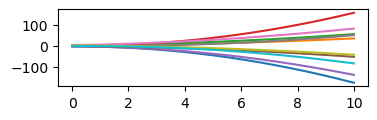

In [3]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor; import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF,DotProduct,ConstantKernel as C
x = np.linspace(0, 10, 200).reshape(-1, 1) # expressed as 2D array

kernel = DotProduct(sigma_0 = 10**0.5, sigma_0_bounds = "fixed") + DotProduct(sigma_0 = 0, sigma_0_bounds = "fixed")**2

gp = GaussianProcessRegressor( kernel, optimizer = None ) 
y_smpl = gp.sample_y( x, n_samples = 10, random_state=0 ) # setting RNG seed w/ random_state
plt.figure(figsize=(4, 1)); plt.plot( x, y_smpl);

### 1.3. periodic / exponential-sine-squared (ESS)
Another useful kernel is the *periodic* or exponential-sine-squared (ESS) kernel 

$$ K(x,x') = \exp \left( - \frac{ 2 \sin^2 (\pi \|x-x'\|_2 / p )}{\ell^2}    \right)$$

This kernel has two parameters: the lenght-scale $\ell$ and the period $p$. It allows you to model repeating patterns with period $p$ because the covariance is the same for inputs which are $p$ units apart in Euclidean distance (i.e., inputs with the same $ \|x-x'\|_2 / p$ value). The code below  generate paths from kernels with different periods :

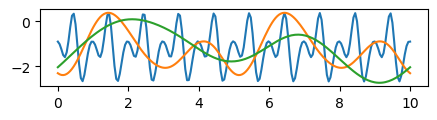

In [4]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor; import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import ExpSineSquared as ESS
x = np.linspace(0, 10, 200).reshape(-1, 1) # expressed as 2D array
plt.figure(figsize=(5, 1));
for i in [1,5,10]:
    y_smpl = GaussianProcessRegressor( ESS( periodicity = i) ).sample_y( x, n_samples = 1, random_state=0 ) 
    plt.plot( x, y_smpl);

## 2. GP Interpolation (gp.fit)

We will use `sklearn`'s `GaussianProcessRegressor` function to fit a GP to data and calculate its posterior. 
For interpolation there is no error term in the model, i.e. we assume $y = f(x) \sim \mathcal{GP}$.
The code below show how to calculate and plot the GP posterior for a Squared Exponential/Radial Basis Function (SE/RBF) kernel. 

### 2.1 Data

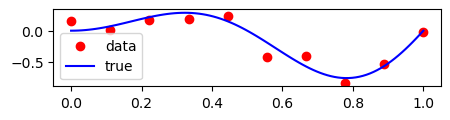

In [5]:
import numpy as np; np.random.seed(1)

N = 10; x = np.linspace(0, 1, N).reshape(-1, 1)  # 2D array
y = np.sin( 2 * np.pi * x ) * x + np.random.normal(0, 1, N).reshape(-1, 1) * .1

# Prediction points & true function 
x_pred = np.linspace(0, 1, 100).reshape(-1, 1)
y_true = np.sin( 2 * np.pi * x_pred ) * x_pred 

plt.figure(figsize=(5, 1));plt.scatter(x, y, color = 'r', label='data');plt.plot(x_pred, y_true, 'b-', label='true')
plt.legend(loc='lower left');

### 2.2. GaussianProcessRegressor Fit & Hyperparameters selection

Scaling the covariance: multiply the RBF kernel with a Constant kernel, and that both **kernels' hyperparameters are selected by maximizing the evidence**. 

This is the designated way to define the kernel when you want to **select/optimize the hyperparameters** (if you did not want to change the parameters, you would multiply by a constant value, rather than by the `ConstantKernel`.)

/opt/conda/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


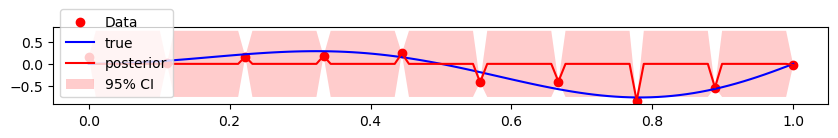

In [6]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor; import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF,DotProduct, ConstantKernel as C, ExpSineSquared as ESS 

kernel = C( ) * RBF( ) 
gp = GaussianProcessRegressor( kernel , random_state=0) # set random state to control for random initial values 
gp.fit(x, y) # training: select hyperparameters that optimize data evidence 
y_pred, sigma = gp.predict(x_pred, return_std=True) # create predictions; i.e. posterior mean 
    
# Plot the results
plt.figure(figsize=(10, 1)); plt.scatter(x, y, color = 'r', label='Data'); plt.plot(x_pred, y_true, 'b-', label='true')
plt.plot(x_pred, y_pred, 'r-', label='posterior')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]), np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% CI')
plt.legend(loc='lower left');

Note that for interpolation, the predictive posterior function will pass through all the data points. 
But sometimes the numerical optimization of the hyperparameters does not work, as in this case. 

In those cases, you can use the kernel parameters to specify the **starting value and search range**, and you can use the **model parameters to adjust (e.g., restart) the optimization**.

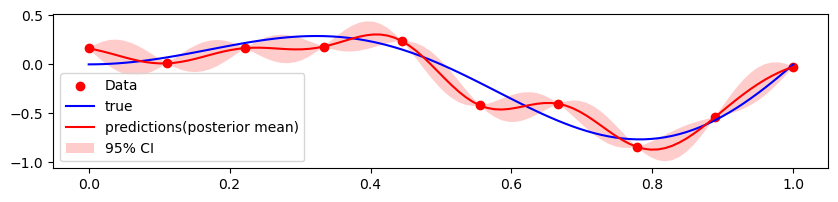

In [7]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor; import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF,DotProduct, ConstantKernel as C, ExpSineSquared as ESS 

kernel = C( constant_value=1, constant_value_bounds=(0.1,10) ) * RBF( length_scale=1, length_scale_bounds=(0.01, 100))
gp = GaussianProcessRegressor( kernel, n_restarts_optimizer=10 ) 
gp.fit(x, y)  # training: select hyperparameters that optimize data evidence 
y_pred, sigma = gp.predict(x_pred, return_std=True)  # create predictions; i.e. posterior mean (y_pred)
    
plt.figure(figsize=(10, 2)); plt.scatter(x, y, color = 'r', label='Data'); plt.plot(x_pred, y_true, 'b-', label='true')
plt.plot(x_pred, y_pred, 'r-', label='predictions(posterior mean)')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]), np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% CI')
plt.legend(loc='lower left');

In [8]:
print(gp.kernel_)  # prints the optimazed kernel hyperparameters 

0.356**2 * RBF(length_scale=0.0869)


#### Other example
Modify the previous code to perform and interpolation using the `RationalQuadratic` (RQ) kernel
$$K(x, x') = \left(
    1 + \frac{|x-x'|^2 }{ 2\alpha  l^2}\right)^{-\alpha}$$

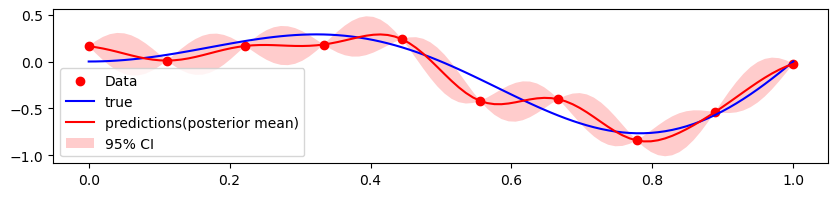

In [9]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor; import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RationalQuadratic as RQ

gp = GaussianProcessRegressor( kernel = C(1.0, (.1, 10)) * RQ( 1.0, 1.0, (1e-2,1e2) ) , n_restarts_optimizer=10 )
gp.fit(x, y)
y_pred, sigma = gp.predict(x_pred, return_std=True)
   
plt.figure(figsize=(10, 2)); plt.scatter(x, y, color = 'r', label='Data')
plt.plot(x_pred, y_true, 'b-', label='true'); plt.plot(x_pred, y_pred, 'r-', label='predictions(posterior mean)')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]), np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% CI')
plt.legend(loc='lower left');

## 3. GP Regression (WhiteNoise)

For GP regression, the data are observed with error $y = f(x) + \varepsilon \sim \mathcal{GP} + \mathcal{N}$.
This means there is an extra $\sigma^2_\varepsilon$ term added to the variance of every observed data point (but NOT of every function evaluation). 
This behavior is modelled with the `WhiteKernel` function in `sklearn`, which gets its name from the [White Noise process](https://en.wikipedia.org/wiki/White_noise). Note that its behavior is different from that of the `ConstantKernel`, which adds a constant to *every* evaluation. Modify the previous code to fit a GP regression with the `ConstantKernel * RBF + WhiteKernel` kernel specification, with optimized hyperparameters.


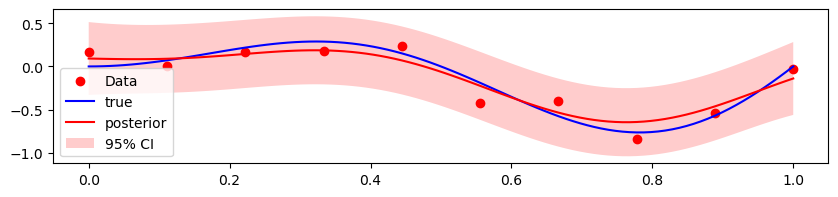

In [10]:
import matplotlib.pyplot as plt;from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel as WN

###
kernel = C(1.0, (.1, 10)) * RBF( 1.0, (1e-2,1e2) ) + WN( noise_level=1, noise_level_bounds=(.01,100) )
gp = GaussianProcessRegressor( kernel , n_restarts_optimizer=10 )
gp.fit(x, y)
y_pred, sigma = gp.predict(x_pred, return_std=True)
   
plt.figure(figsize=(10, 2));  plt.scatter(x, y, color = 'r', label='Data')
plt.plot(x_pred, y_true, 'b-', label='true'); plt.plot(x_pred, y_pred, 'r-', label='posterior')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]), np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% CI')
plt.legend(loc='lower left');